# pyPCGA modflow inversion example

Colab Example (10/27/2022): https://colab.research.google.com/drive/1djVDZNjh390czXlzBbu7FvRQne9mf8SP?usp=sharing
Requirements : Flopy (tested in ver 3.2.9)

For Flopy installation and execution, please see http://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/schedule.html

 

## Crosswell tomography

- Adapted from Application 1 of Lee and Kitanids [WRR 2014] 

(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR015483)

***

> We first generated 870 head observations using crosswell pumping tests (ln 9) from the true log K field (ln 11) with USGS MODFLOW Flopy python interface.

> In specific, we extracted groundwater at a well and observed 29 stready-state hydraulic heads at the remaining monitoring wells. We repeated these crosswell pumping tests for all 30 well locations (ln 11).  

> Then add the noise (std = 0.5) to observations. Using observations with MODFLOW, can we reconstruct the true field (ln 11)?

Note the example is not exactly same as Application 1 in Lee and Kitanidis [2014]

Also, the number of MODFLOW simulations is higher than what they reported because we turned on Levenberg-Marquardt and Line Search options in this example. Those additional optimization routines increases the inversion time, but usually results in a very accurate inverse solution even for highly nonlinear problems. 

***

- Parameters

|Description           |                      |   Value |            
|----------------------|:----------------------------------:|:---------------------------:|
|*Geomteric parameters*                          | |       |                                               
| Lx, Ly        | Domain length and width (m)        |        1000, 750|         
| Q             | Pumping rates (m^2/d)              |            25 |           
| Rch           | Recharge rates (m/d)               |           0.001|          
| dx, dy        | Grid size (m)                      |            10|            
|*Geostatistical parameters*     ||                      |                        
| true mean(logK)    | mean for the true log K (ln m/d) |            2.5  |          
| true q(x,x')       | Covariance kernel for the true log K                  | q(x,x') = 0.002^3 (x-x')^3 |
| q(x,x')            | Covariance kernel used in inversion | q(x,x') = exp(-x/250) |
|*Measurement Error* ||  |
| nobs | Number of measurement | 870 |
| R | Variance of measurement error (m) | 0.5^2 |


In [1]:
%matplotlib  inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyPCGA import PCGA
import mf
import math
import datetime as dt
import os

- Model domain and discretization for USGS MODFLOW-flopy

In [3]:
Lx = 1000.; Ly = 750.; Lz = 1; nlay = 1; nrow = 75; ncol = 100
Q = 25.; Rch = 0.001
ztop = 0.; zbot = -1.

- Inputs for coraviance function (used for FFT-based cov. mat-vec multiplication): it seems confusing, but python array in order of col, row and lay

In [4]:
N = np.array([ncol, nrow, nlay])
m = np.prod(N)
dx = np.array([10., 10., 1.])
xmin = np.array([0. + dx[0] / 2., 0. + dx[1] / 2., 0. + dx[2] / 2.])
xmax = np.array([Lx - dx[0] / 2., Ly - dx[1] / 2., Lz - dx[2] / 2.])

- Covariance kernel and scale parameters

In [5]:
prior_std = 1.0
prior_cov_scale = np.array([250., 250., 1.])

def kernel(r): return (prior_std ** 2) * np.exp(-r)

- Specify executable and input/simulation directories for USGS MODFLOW-flopy simulation

In [6]:
if os.name == 'nt':
    mf_exec = 'mf2005.exe'
else:
    mf_exec = 'mf2005'

input_dir = "./input_files"
sim_dir = './simul'

- Location of observations (obs_locmat)

In [7]:
obs_locmat = np.zeros((nlay, nrow, ncol), np.bool)
for i in range(5, 71, 16):
    for j in range(9, 96, 16):
        obs_locmat[0, i, j] = 1

- x,y coordinates for plotting

In [8]:
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

- Pumping/monitoring well locations

Text(0.5,1,'well locations')

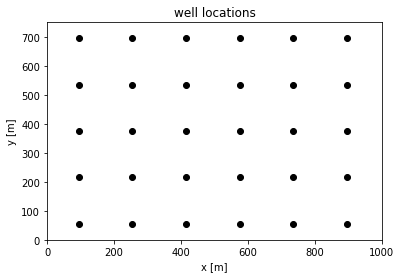

In [9]:
idx = np.where(obs_locmat == 1)
for i,j in zip(idx[1],idx[2]):
    plt.plot(x[j],y[i],'ko')
plt.xlim(0,Lx)
plt.ylim(0,Ly)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('well locations')

- This example is Hydraulic tomography - crosswell pumping test setting

In [10]:
Q_locs_idx = np.where(obs_locmat == True)
Q_locs = []
for Q_loc in zip(Q_locs_idx[0], Q_locs_idx[1], Q_locs_idx[2]):
    Q_locs.append(Q_loc)

- Load true value for comparison purpose with its plot

Text(0.5,1,'true logK')

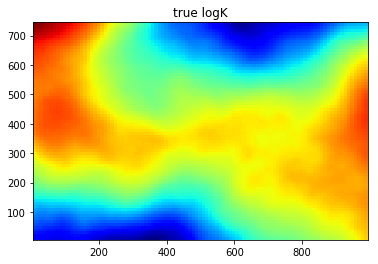

In [11]:
s_true = np.loadtxt('true_logK.txt')
s_true = np.array(s_true).reshape(-1, 1)  # make it 2D array
s_true3d = s_true.reshape(nlay, nrow, ncol)
s_true2d = s_true3d[0,:,:]
plt.pcolormesh(XX,YY,s_true2d, cmap=plt.get_cmap('jet'))
plt.title('true logK')

- Load observations

In [12]:
obs = np.loadtxt('obs.txt')

- Modflow Flopy parameters

In [13]:
mf_params = {'mf_exec': mf_exec, 'input_dir': input_dir,
          'sim_dir': sim_dir,
          'Lx': Lx, 'Ly': Ly,
          'Q': Q, 'Rch': Rch,
          'nlay': nlay, 'nrow': nrow, 'ncol': ncol,
          'zbot': zbot, 'ztop': ztop,
          'obs_locmat': obs_locmat, 'Q_locs': Q_locs}

- Prepare interface to run as a function


In [14]:
def forward_model(s, parallelization, ncores=None):
    model = mf.Model(mf_params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

- PCAG inversion parameters

In [15]:
params = {'R': (0.5) ** 2, 'n_pc': 50,
          'maxiter': 10, 'restol': 0.01,
          'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
          'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
          'kernel': kernel, 'post_cov': "diag",
          'precond': True, 'LM': True,
          'parallel': True, 'linesearch': True,
          'forward_model_verbose': False, 'verbose': False,
          'iter_save': True}

- Initial guess you have to provide. In most cases, intial guess does not affect the final results.

In [16]:
s_init = np.ones((m, 1))

### PCGA initialization

In [17]:
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                            : 7500
   Number of observations                        : 870
   Number of principal components (n_pc)         : 50
   Prior model                                   : def kernel(r): return (prior_std ** 2) * np.exp(-r)

   Prior variance                                : 1.000000e+00
   Prior scale (correlation) parameter           : [250. 250.   1.]
   Posterior cov computation                     : diag
   Posterior variance computation                  : Approx.
   Number of CPU cores (n_core)                  : 4
   Maximum GN iterations                         : 10
   machine precision (delta = sqrt(precision))   : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol)) : 1.000000e-02
   Levenberg-Marquardt                           : True
   Line search                                   : 

### PCGA run

In [18]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 7500) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 1 sec
- 1st eigv : 1782.68, 50-th eigv : 11.2903, ratio: 0.00633333
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 28.9211, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 57.8421
***** Iteration 1 ******
computed Jacobian-Matrix products in 36.515916 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
- Geostat. inversion at iteration 1 is 39 sec
== iteration 1 summary ==
= objective function is 1.396249e+05, relative L2-norm diff btw sol 0 and sol 1 is 0.836224
= L2-norm error (w.r.t truth) is 0.363889, obs. RMSE is 8.95781, obs. normalized RMSE is 17.9156
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 38.150950 secs
solve saddle 

## Post-processing

- reshape the solution to 2d array for visualization

In [19]:
s_hat3d = s_hat.reshape(nlay, nrow, ncol)
s_hat2d = s_hat3d[0,:,:]
s_true3d = s_true.reshape(nlay, nrow, ncol)
s_true2d = s_true3d[0,:,:]

post_diagv[post_diagv < 0.] = 0.  # just in case
post_std = np.sqrt(post_diagv)
post_std3d = post_std.reshape(nlay, nrow, ncol)
post_std2d = post_std3d[0,:,:]

minv = s_true.min()
maxv = s_true.max()

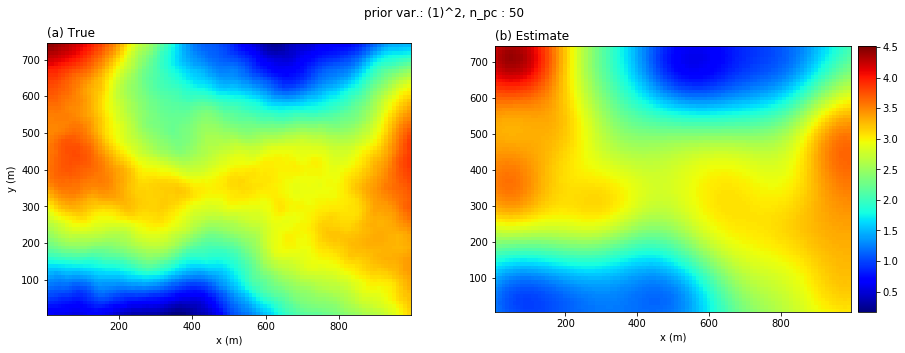

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('prior var.: (%g)^2, n_pc : %d' % (prior_std, params['n_pc']))
im0 = axes[0].pcolormesh(XX,YY,s_true2d, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes[0].set_title('(a) True', loc='left')
axes[0].set_aspect('equal')
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[0].axis([XX.min(), XX.max(), YY.min(), YY.max()])
im1 = axes[1].pcolormesh(XX, YY, s_hat2d, vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes[1].set_title('(b) Estimate', loc='left')
axes[1].set_xlabel('x (m)')
axes[1].set_aspect('equal')
axes[1].axis([XX.min(), XX.max(), YY.min(), YY.max()])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[1])
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()


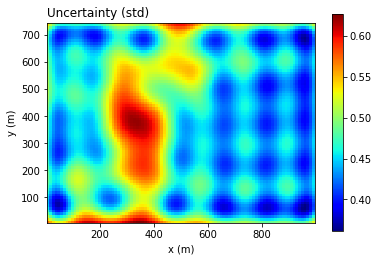

In [21]:
fig = plt.figure()
im = plt.pcolormesh(XX,YY,post_std2d, cmap=plt.get_cmap('jet'))
plt.axis([XX.min(), XX.max(), YY.min(), YY.max()])
plt.title('Uncertainty (std)', loc='left')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(im)
plt.show()

- Observation mismatch

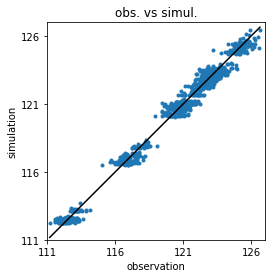

In [22]:
nobs = prob.obs.shape[0]
fig = plt.figure()
plt.title('obs. vs simul.')
plt.plot(prob.obs, simul_obs, '.')
plt.axis('equal')
plt.axis('square')
plt.xlabel('observation')
plt.ylabel('simulation')
minobs = np.vstack((prob.obs, simul_obs)).min(0)
maxobs = np.vstack((prob.obs, simul_obs)).max(0)
plt.xlim([math.floor(minobs), math.ceil(maxobs)])
plt.ylim([math.floor(minobs), math.ceil(maxobs)])
plt.xticks(np.arange(math.floor(minobs), math.ceil(maxobs), 5))
plt.yticks(np.arange(math.floor(minobs), math.ceil(maxobs), 5))

plt.plot(np.linspace(minobs, maxobs, 20), np.linspace(minobs, maxobs, 20), 'k-')
plt.show()


- Objective values over iteration

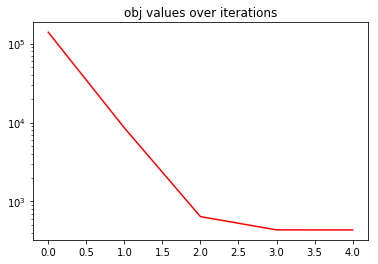

In [23]:
fig = plt.figure()
plt.semilogy(range(len(prob.objvals)), prob.objvals, 'r-')
plt.title('obj values over iterations')
plt.axis('tight')
plt.show()

- Eigenvectors of covariacne

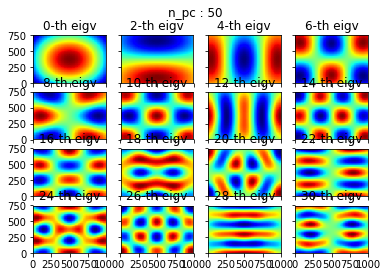

In [24]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True)
fig.suptitle('n_pc : %d' % params['n_pc'])
for i in range(4):
    for j in range(4):
        tmp3d = prob.priorU[:, (i * 4 + j) * 2].reshape(nlay,nrow,ncol)
        axes[i, j].pcolormesh(XX,YY,tmp3d[0,:,:],cmap=plt.get_cmap('jet'))
        axes[i, j].set_title('%d-th eigv' % ((i * 4 + j) * 2))
        axes[i, j].axis([XX.min(), XX.max(), YY.min(), YY.max()])
plt.show()
plt.close(fig)

- Eigenvalue decay of the prior covariance

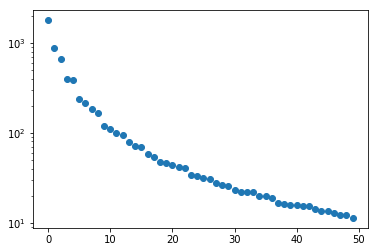

In [25]:
fig = plt.figure()
plt.semilogy(prob.priord, 'o')
#fig.savefig('eig.png', dpi=fig.dpi)
plt.show()
